### ARMAX Models
Before jumping into Data-enabled Predictive Control (DeePC) we will introduce a dummy system in which we will be carrying out experiments. This system shall be an ARMAX process, which a Linear Time Invariant system governed by the following transfer function.
$$A(z) y(t) = C(z) e(t) + B(z) u(t)$$

- $y$: System Output
- $e$: Non-deterministic Noise
- $u$: System Output
- $A(z) = 1 - a_1 z^{-1} - a_2 z^{-2} ... $ 
- $B(z) = b_0 + b_1 z^{-1} + b_2 z^{-2} ... $ 
- $C(z) = c_0 + c_1 z^{-1} + c_2 z^{-2} ... $ 

Leaving us the time difference equation:

$$ y(t) = -\left(a_1 y(t-1) + a_2 y(t-2) +... +a_{na} y(t-na)\right)+... \\
c_0 * e(t) + c_1 * e(t-1)+ ... +  c_{nc} * e(t-nc)+ ... \\  
b_0 * u(t) + b_1 * u(t-1)+ ... +  b_{nb} * u(t-nb)  $$ 

- $u \in R^m$
- $y \in R^p $

For simplicity in this example we will focus on SISO systems. 

In [118]:
# Install Packages needed for this example
using Pkg
# Pkg.add("Random")
# Pkg.add("LinearAlgebra")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("JuMP")
# Pkg.add("Ipopt")
# Pkg.add("MultiObjectiveAlgorithms")
# Pkg.add("Ipopt")
# Pkg.add("Statistics")
# Pkg.add("StatsPlots")
# Pkg.add("MathOptInterface")


   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [b8f27783] + MathOptInterface v1.16.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`



ARMAX: y(t) = (1-A(z)) y(t) + B(z)u(t) + C(z)e(t)
Coeffs of 1-A(z): [0.5, 0.25, 0.125]
Coeffs of B(z): [0.3966450554650819]
Coeffs of C(z): [-0.20918333558208346, -0.3566816170797491, -0.013307061177314838]


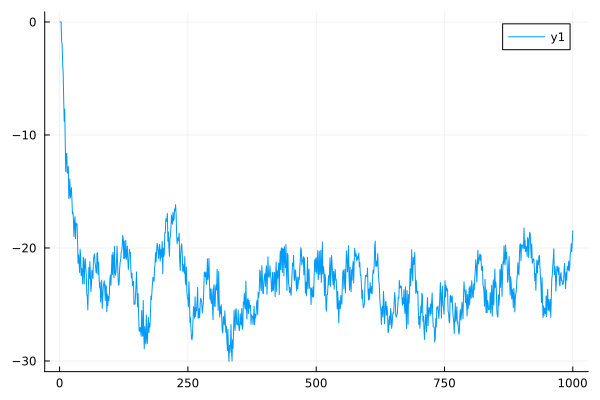

In [176]:
# ARMAX process generator
# A * y = C * e + B * u
# y - Output signal
# e - Random Noise
# u - Exogenous Input
using Random, LinearAlgebra, Plots

SimT=1000
na=3;nb=1;nc=3;
m=1;p=1;
# A_coeffs = rand(Float64,(na)).-0.5 # Coefficients of 1-A
# C_coeffs = (rand(Float64,(nc)).-0.5) # Coefficients of C
# B_coeffs = rand(Float64,(nb)).-0.5 # Coefficients of B
# A_coeffs = (1/2).^(1:na)

# This model presents nice curves  
A_coeffs = [0.5, 0.25, 0.125]
B_coeffs = [0.3966450554650819]
C_coeffs = [-0.20918333558208346, -0.3566816170797491, -0.013307061177314838]


# t = range(1, SimT, length=SimT)
t=1:SimT
y = collect(t.*0.0) # Noise Generator
e = (rand(Float64, ( SimT)).-0.5).*10 .+ 5 # Noise Generator
# e = rand(Float64, ( SimT)) # Noise Generator
u = rand(Float64, ( SimT)).-0.5 # Noise Generator

# println(B_coeffs)
# println(y)
max_n = max(na,nb,nc)
println()
println("ARMAX: y(t) = (1-A(z)) y(t) + B(z)u(t) + C(z)e(t)")
println("Coeffs of 1-A(z): $(A_coeffs)")
println("Coeffs of B(z): $(B_coeffs)")
println("Coeffs of C(z): $(C_coeffs)")
for i in t
    y[i] = i>max_n ? dot(y[(i-na):(i-1)],A_coeffs) + dot(e[(i-nc+1):i],C_coeffs) + dot(u[(i-nb+1):i],B_coeffs) : 0
    
    # if i>max_n
    #      # println(dot(y[(i-na):(i-1)],A_coeffs))
    #     # println(dot(e[(i-nc+1):i],C_coeffs))
    #     # println((i-nb+1):i)
    #     # println(dot(u[(i-nb+1):i],B_coeffs))
    # end
end

# println(y)
# using Plots
plot(t,y)
# print(size(t))
# print(size(e))

# Can the stock price be modelled locally as an ARMAX model?


# DeePC

This section generically addresses the topic of Data Enabled Predictive Control (DeePC). Formulates are taken from:
> J. Coulson, J. Lygeros and F. Dörfler, "Data-Enabled Predictive Control: In the Shallows of the DeePC," 2019 18th European Control Conference (ECC), Naples, Italy, 2019, pp. 307-312, doi: 10.23919/ECC.2019.8795639.




### DeePC Algorithm
The algorithm below is presented for LTI systems with an unkown model, this is a system defined by the equation below where the matrices A, B, C, D are unknown.

$$
\left\{
    \begin{array}\\
        x(t+1)= A x(t) + B  u(t)) \\
        y(t)= C x(t) + D u(t)\\
        \end{array}
\right.
$$

The DeePC algorithm intends to solve the Optimal Control Problem below:

$$
\min_{g,u,y} 
    \sum_{k=0}^{N-1}\left(|y_k-r_{t+k}|_Q^2 + |u_k|_R^2\right)  \\
    s.t.\\
\begin{pmatrix} U_p \\ Y_p \\ U_f \\ Y_f \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \\ u \\ y \end{pmatrix}
    $$

- $u$ and $y$ are not independent decision variables , they are defined by the matrices $U_f$ and  $Y_f$
- The decision variable is just $g$ because we can define u and y as follows
$$u=U_fg\\y=Y_fg$$

Then the problem becomes:

$$\min_g \sum_{k=0}^{N-1} \left(|\left(Y_fg\right)_k-r_{t+k}|_Q^2 +\left(U_fg\right)_k|_R^2    \right) $$
    
$$    s.t.\\
\begin{pmatrix} U_p \\ Y_p \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \end{pmatrix}$$

##### Hankel Matrix
- $L$
- $T$ with $T \geq L $
$$H_L(u)= \begin{Bmatrix}
u_1 & \cdots & u_{T-L+1}\\
\vdots & \ddots & \vdots\\
u_L & \cdots & u_T
\end{Bmatrix}$$
- $H_L(u)$ needs to be full row rank for u to be persistently exiting of order L, meaning that all the rows of $H_L(u)$ need to be independent.

In [182]:

# Having the data let's say that the problem is to minimize 
# the absolute value of y and to small degree of u 


ts = 250 # Timestamp we pick
# T: Number of data points T>= (m+1)*(T_ini+N+n(B))-1, where n(B) is the smallest state dimension

# T-L+1: Number of block columns in Hankel matrix
# L : Number of block rows in the hankel matrix (Needs to be the same as block elements in u_ini) : T_ini
# If I make L=T Then hankel matrix will be a column vector 

N=25 # Future Horizon (N block rows)
T_ini=50 # Past Horizon (T_ini block rows)

# Objective find vector g that minimizes the expression above
# Each column 

using LinearAlgebra, DataFrames
R= kron(I(25),0.25)
Q= kron(I(25),100)

nB=1; # This is an unknown, in practice one just collects necessary amount of data
# to have persistency of excitation, meaning to have independent rows
# The number of columns in the hankel matrix is increased until rows are independent

minT=(m+1)*(T_ini+N+nB)-1

u_ini = u[(ts-T_ini+1):ts]
y_ini = y[(ts-T_ini+1):ts]
# HLu  n

# n_rows= (N+T_ini)*m; # The number of rows are enough to represent a trajectory 
# of inputs over N+T_ini steps

# The number of columns need to be at least equally rich?
# n_columns = n_rows; # This will give you square matrices for Up and Yp when SISO
n_columns = size(u_ini)[1]*m+ size(y_ini)[1]*p; # This will provide feasibility
# n_columns = n_columns + 100  ; # This will introduce 5 degrees of freedom

HLu =zeros((N+T_ini)*m,n_columns)
HLy =zeros((N+T_ini)*p,n_columns)


#%%
i=1
println("Present Time: $(ts)")
println("Number of Rows: $n_rows")

# We need to build the matrix 
# println((ts-i+1)-n_rows+1:(ts-i+1))
# println(size(u[(ts-i+1)-n_rows+1:(ts-i+1),:]))

####################### Compute HLu
for i = 1:n_columns
    HLu[:,i]= u[(ts-i+1)-(N+T_ini)*m+1:(ts-i+1),:]
end

if rank(HLu)>=(N+T_ini)*m
    println("Congrats HLu is row full rank.")
else
    println("HLu is not yet full row rank, consider adding more columns.") 
end

####################### Compute HLy
for i = 1:n_columns
    HLy[:,i]= y[(ts-i+1)-(N+T_ini)*p+1:(ts-i+1),:]
end

if rank(HLy)>=(N+T_ini)*p
    println("Congrats HLy is row full rank.")
else
    println("HLy is not yet full row rank, consider adding more columns.") 
end
# To be in line with the paper we need to flip HLu, but it should not make a difference.
# HLu=reverse(HLu,dims=2)


Up = HLu[1:T_ini*m,:] 
Yp = HLy[1:T_ini*p,:]
Uf = HLu[T_ini*m+1:end,:] 
Yf = HLy[T_ini*p+1:end,:]
# println(u)
# println(minT)
# println(size(u_ini))
# println(size(HLu))
# R
println("Size of Hankel Matrix HLu: $(size(HLu)). Rank: $(rank(HLu)).")
println("Size of Hankel Matrix HLy: $(size(HLy)). Rank: $(rank(HLy)).")
println("Size of Up: $(size(Up)). Rank: $(rank(Up)).")
println("Size of Yp: $(size(Yp)). Rank: $(rank(Yp)).")
println("Size of Uf: $(size(Uf)). Rank: $(rank(Uf)).")
println("Size of Yf: $(size(Yf)). Rank: $(rank(Yf)).")

g = rand(Float64, size(Up)[2] )
cost = (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g) 

Present Time: 250
Number of Rows: 75
Congrats HLu is row full rank.
Congrats HLy is row full rank.
Size of Hankel Matrix HLu: (75, 100). Rank: 75.
Size of Hankel Matrix HLy: (75, 100). Rank: 75.
Size of Up: (50, 100). Rank: 50.
Size of Yp: (50, 100). Rank: 50.
Size of Uf: (25, 100). Rank: 25.
Size of Yf: (25, 100). Rank: 25.


3.59718761832389e9

100

In [119]:
using JuMP
using Ipopt
import MathOptInterface as MOI

In [178]:
# Note: Since there is noise in the process, there won't be any g
# such that Up*g = u_ini and Yp * g = y_ini, if Up and Yp are square matrices.

# To make the problem feasible I need to add more columns to Up and Yp.

# The solution design is heavily based on the example contributed by Arpit Bhatia
# at https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/portfolio/

model = Model(Ipopt.Optimizer)
# set_optimizer(model, Ipopt.Optimizer)
# set_silent(model)
@variable(model, g[1:size(Up)[2]])
@objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g))
@constraint(model, Yp*g == y_ini)
@constraint(model, Up*g == u_ini)
# @constraint(model, sum(x) <= 1000)



optimize!(model)
solution_summary(model)


function SolveDeePC(Up,Uf,Yp,Yf,Q,R,y_ini,u_ini)
    model = Model(Ipopt.Optimizer)
    @variable(model, g[1:size(Up)[2]])
    @objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g))
    @constraint(model, Yp*g == y_ini)
    @constraint(model, Up*g == u_ini)
    optimize!(model)
    return model
end
    

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:    10000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.45e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 1.14890e+06
  Dual objective value : 2.29780e+06

* Work counters
  Solve time (sec)   : 3.10998e-02


### Regularized Optimization problem
This allows DeePC tto be extended beyond LTI system like non-deterministic and nonlinear systems.
$$
\left\{
    \begin{array}\\
        x(t+1)= f(x(t),u(t)) \\
        y(t)= h(x(t),u(t),\nu(t)) \\
        \end{array}
\right.
$$
Where $\nu$ is noise

$$
\min_{g,u,y,\sigma_y} 
    \sum_{k=0}^{N-1}\left(|y_k-r_{t+k}|_Q^2 + |u_k|_R^2\right) 
    + \lambda_g |g|_1
    + \lambda_y |\sigma_y|_1 \\
    s.t.\\
\begin{pmatrix} U_p \\ Y_p \\ U_f \\ Y_f \end{pmatrix} * g = \begin{pmatrix} u_{ini} \\ y_{ini} \\ u \\ y \end{pmatrix} + \begin{pmatrix} 0 \\ sigma_y \\ 0 \\ 0 \end{pmatrix}
    $$
    
##### Slack Variable $\sigma_y$
This variable is  introduced to cope with noise, when noise is present the constraint may become unfeasible, therefore a  slack variable is introduced and penalized with a large $\lambda_y$. Without this term the constraint may become unfeasible.

##### One-norm regularization on g
It is assumed this term helps to bring robustness to the solution of the Optimal Control Problem (OCP) 




In [180]:
model = Model(Ipopt.Optimizer)

lambda_y = 5000;
lambda_g = 100;
@variable(model, g[1:size(Up)[2]])
@variable(model, sigma_y[1:size(y_ini)[1]])
@variable(model, norm_1_sigma_y>=0)
@variable(model, norm_1_g>=0)

@objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g) + lambda_y*norm_1_sigma_y + lambda_g*norm_1_g  )

@constraint(model, Yp*g == y_ini + sigma_y)
@constraint(model, Up*g == u_ini)

@constraint(model, [norm_1_sigma_y; sigma_y] in MOI.NormOneCone(1 + length(sigma_y)))
@constraint(model, [norm_1_g; g] in MOI.NormOneCone(1 + length(g)))

optimize!(model)
solution_summary(model)
JuMP.value.(g)

function SolveDeePC(Up,Uf,Yp,Yf,Q,R,y_ini,u_ini,lambda_y,_lambda_g)
    model = Model(Ipopt.Optimizer)
    @variable(model, g[1:size(Up)[2]])
    @variable(model, sigma_y[1:size(y_ini)[1]])
    @variable(model, norm_1_sigma_y>=0)
    @variable(model, norm_1_g>=0)
    @objective(model, Min, (Yf*g)'*Q*(Yf*g) + (Uf*g)'*R*(Uf*g) + lambda_y*norm_1_sigma_y + lambda_g*norm_1_g  )
    @constraint(model, Yp*g == y_ini + sigma_y)
    @constraint(model, Up*g == u_ini)
    @constraint(model, [norm_1_sigma_y; sigma_y] in MOI.NormOneCone(1 + length(sigma_y)))
    @constraint(model, [norm_1_g; g] in MOI.NormOneCone(1 + length(g)))
    optimize!(model)
    return model
end

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:    10050
Number of nonzeros in inequality constraint Jacobian.:      752
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      302
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      302
        inequality constraints with only lower bounds:      302
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0999949e+01 2.45e+01 9.19e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

100-element Vector{Float64}:
 -1.2524618338738933
 -0.27029913468483674
 -0.10366649538257514
 -0.1957204422940943
 -0.5198811612865193
  1.0421930204829501
 -0.1721487312497739
  0.010604666725029143
  0.35604327533802627
  0.2640160034358106
 -0.650956276231874
  0.6649289600815105
  0.23857621603556015
  ⋮
 -0.15987552285958972
  0.8657075264037821
 -0.5310078323136168
  0.07576638405120469
 -0.46593706318179423
  0.24339897032673766
 -0.4820605477981588
 -0.007845087270205508
  0.5330246398961636
 -0.05347307644746939
 -0.09009381638881213
 -0.4456084794269717

49.226415784525464

Quadratic error: 164001.00446172286


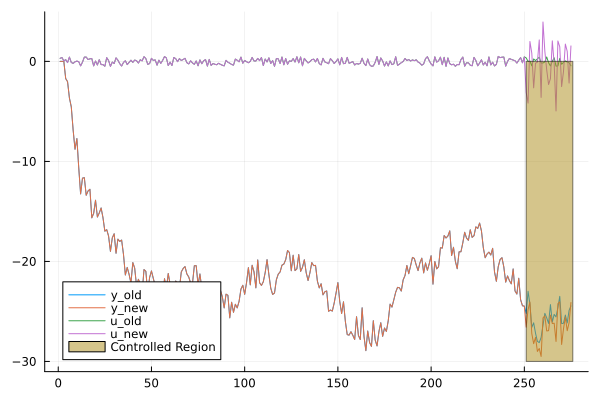

In [181]:
gs = JuMP.value.(g)
println("Quadratic error: $((Yf*gs)'*Q*(Yf*gs) + (Uf*gs)'*R*(Uf*gs) )")
t_f=ts+1:ts+N
y_f = deepcopy(y)
e_f = deepcopy(e)
u_f = deepcopy(u) # Noise Generator

# Replace random initial inputs with the optimized ones 
u_f[t_f] = Uf*gs

for i in t_f
    y_f[i] = i>max_n ? dot(y_f[(i-na):(i-1)],A_coeffs) + dot(e_f[(i-nc+1):i],C_coeffs) + dot(u_f[(i-nb+1):i],B_coeffs) : 0
end

plot(t[1:ts+N],y[1:ts+N],lab="y_old")
plot!(t[1:ts+N],y_f[1:ts+N],lab="y_new")
plot!(t[1:ts+N],u[1:ts+N],lab="u_old")
plot!(t[1:ts+N],u_f[1:ts+N],lab="u_new")

rectangle(w, h, x_og, y_og) = Shape(x_og .+ [0,w,w,0], y_og .+ [0,0,h,h])
plot!(rectangle(N,30,ts+1,-30), opacity=.5,lab="Controlled Region")

In [164]:
DataFrame([u_f[t_f],u[t_f],Uf*gs],:auto)

Row,x1,x2,x3
,Float64,Float64,Float64
1,-0.0689232,-0.0689232,-0.0689232
2,0.0116157,0.0116157,0.0116157
3,-0.133383,-0.133383,-0.133383
4,-0.0137525,-0.0137525,-0.0137525
5,0.0537485,0.0537485,0.0537485
6,-0.0519376,-0.0519376,-0.0519376
7,0.00360365,0.00360365,0.00360365
8,-0.12183,-0.12183,-0.12183
9,0.22296,0.22296,0.22296


25